In [1]:
import torch
import torchvision.transforms as T
from torch import nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
from base64 import b64encode
from tqdm import tqdm
import numpy as np
import os
import cv2
from IPython.display import Video


In [2]:
def show_grid(maxn=20, w=3, h=3):
    """Assuming images have been saved in steps/ and there are
    at least maxn of them with the naming convention 0001.jpeg.
    This function loads w x h images and shows them in a grid.
    Useful for a quick preview to see if anything interesting is
    happening"""
    fig, axs = plt.subplots(h, w)
    plt.tight_layout()
    for x in range(h):
        for y in range(w):
            i = int(maxn * (x * w + y) / (w * h))
            axs[x][y].imshow(Image.open(f"steps/{i:05}.jpeg"))


def render(ca, n=100, w=256, h=256, save_every=1, exp_frac=0, display_grid=True):
    """Render n steps of a ca starting from a random grid.
    Saves an image every save_every steps into the steps/ folder.
    Smooths the aniation with exponential averaging set by exp_frac
    """
    !rm -r steps
    !mkdir steps
    grid = torch.rand(1, 1, w, h)  # bs, channels, w, h
    im_array = np.array(grid[0][0].clip(0, 1))
    for i in tqdm(range(n)):
        grid = ca(grid)
        im_array = exp_frac * im_array + (1 - exp_frac) * np.array(
            grid[0][0].clip(0, 1)
        )
        im = Image.fromarray(np.uint8(cm.gist_earth(im_array) * 255)).convert("RGB")
        if i % save_every == 0:
            im.save(f"steps/{i//save_every:05}.jpeg")
    if display_grid:
        show_grid(maxn=30, w=3, h=2)


def progress_video(name="nca.mp4"):
    """
    Create a video from the images saved in the steps/ folder."""
    path = "steps/"
    out_video_name = "temp_nca.mp4"
    out_video_full_path = out_video_name

    pre_imgs = os.listdir(path)
    pre_imgs.sort()
    # print(pre_imgs)
    img = []
    # exit()
    for i in pre_imgs:
        i = path + i
        # print(i)
        img.append(i)

    # print(img)

    cv2_fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    frame = cv2.imread(img[0])
    size = list(frame.shape)
    del size[2]
    size.reverse()
    # print(size)

    video = cv2.VideoWriter(
        out_video_full_path, cv2_fourcc, 24, size
    )  # output video name, fourcc, fps, size

    for i in range(len(img)):
        video.write(cv2.imread(img[i]))

    video.release()
    !ffmpeg -y -i temp_nca.mp4 $name -loglevel quiet
    !rm -f temp_nca.mp4


In [3]:
# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import random

seed = 2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

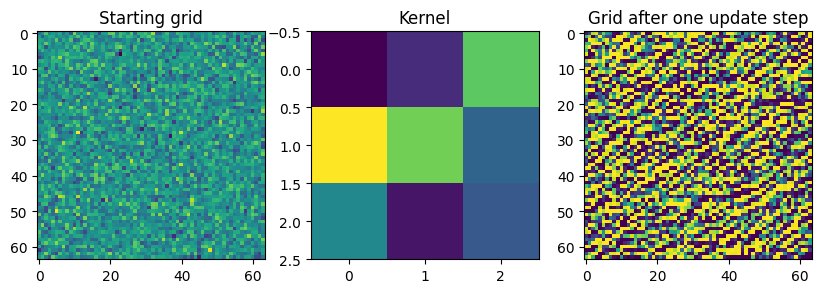

In [5]:
# Create our grid (32x32 for this demo)
grid = torch.randn(1, 1, 64, 64)  # batch_size, channels, w, h

# Create a random kernel
kernel = torch.randn(1, 1, 3, 3)  # batch_size, channels, kernel_size, kernel_size

# Define an activation function
act = torch.tanh

# Compute the output after one step:
output = act(
    F.conv2d(grid, kernel, padding="same")
)  # Think: What happens to the sizes if we remove padding?

# Visualize the various arrays:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(grid[0][0])
axs[0].set_title("Starting grid")
axs[1].imshow(kernel[0][0])
axs[1].set_title("Kernel")
axs[2].imshow(output[0][0])
axs[2].set_title("Grid after one update step")
plt.show()

In [6]:
class ConvCA(nn.Module):
    """Applies a convolutional kernel over an image and passes the result through
    an activation function."""

    def __init__(self, kernel_size=3, kernel_scale=0.5, act=torch.tanh):
        # @param kenel_scale : update scale rate of the kernel

        super().__init__()
        self.kernel = torch.randn(1, 1, kernel_size, kernel_size) * kernel_scale
        self.act = act

    def forward(self, x):
        return self.act(F.conv2d(x, self.kernel, padding=1))

100%|██████████| 100/100 [00:00<00:00, 333.21it/s]


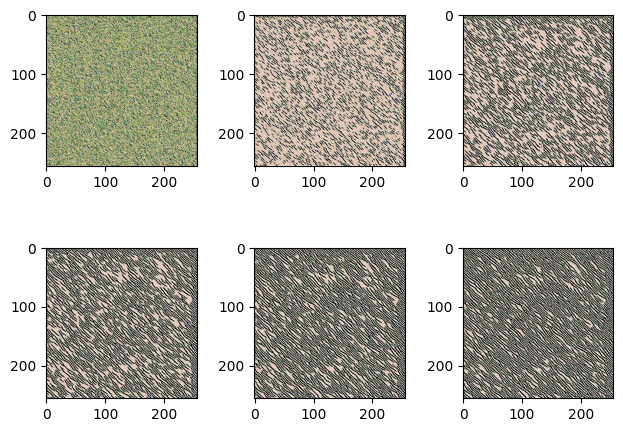

In [7]:
ca = ConvCA(kernel_scale=0.5)
render(ca)

In [8]:
# Convert step images to video
progress_video(name="random_ca.mp4")
Video("random_ca.mp4", width=500, height=500)

In [9]:
render(ca, n=1000, save_every=1, exp_frac=0.8, display_grid=False)

# Convert step images to video
name = "random_ca_smooth.mp4"
progress_video(name)
Video(name, width=500, height=500)

100%|██████████| 1000/1000 [00:02<00:00, 366.29it/s]


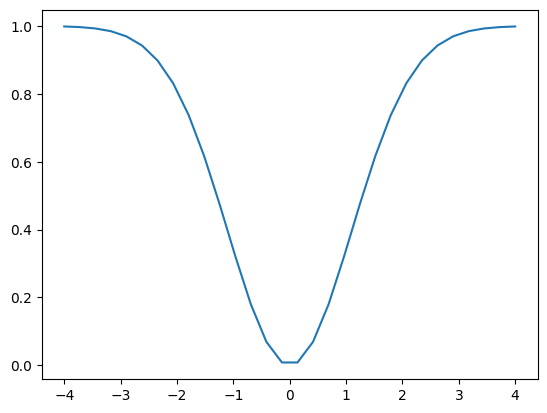

In [10]:
def inverse_gaussian(x):
    return -1.0 / torch.pow(2.0, (0.6 * torch.pow(x, 2.0))) + 1.0


# Plot:
x = torch.linspace(-4, 4, 30)
plt.plot(x, inverse_gaussian(x))

In [11]:
worm_ca = ConvCA(act=inverse_gaussian)
worm_ca.kernel = torch.tensor(
    [[[[0.68, -0.9, 0.68], [-0.9, -0.6, -0.9], [0.68, -0.9, 0.68]]]]
)
render(worm_ca, n=2000, save_every=10, exp_frac=0.8, display_grid=False)

name = "worms_nca.mp4"
progress_video(name=name)
Video(name, width=500, height=500)

100%|██████████| 2000/2000 [00:05<00:00, 335.69it/s]


In [22]:
def swich(x):
	return x * torch.sigmoid(x)

def mish(x):
	return x * torch.tanh(nn.functional.softplus(x))

def elish(x):
    return torch.where(x > 0, x * torch.sigmoid(x), (torch.exp(x) - 1) * torch.sigmoid(x))

worm_ca = ConvCA(act=elish)
render(worm_ca, n=2000, save_every=10, exp_frac=0.8, display_grid=False)

name = "relu_nca.mp4"
progress_video(name=name)
Video(name, width=500, height=500)

100%|██████████| 2000/2000 [00:05<00:00, 333.67it/s]


In [13]:
worm_ca = ConvCA(act=torch.tanh)
render(worm_ca, n=2000, save_every=10, exp_frac=0.8, display_grid=False)

name = "tanh_nca.mp4"
progress_video(name=name)
Video(name, width=500, height=500)

100%|██████████| 2000/2000 [00:04<00:00, 430.61it/s]


# NCA

In [14]:
class NeuralCA(nn.Module):
	def __init__(self, channel_n=4, fire_rate=0.5, hidden_n=16, device=device):
		super().__init__()
		self.fire_rate = fire_rate
		self.channel_n = channel_n
		self.hidden_n = hidden_n
		self.device = device
		self.conv1 = nn.Conv2d(channel_n, hidden_n, 1).to(device)
		self.conv2 = nn.Conv2d(hidden_n, channel_n, 1).to(device)

	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = F.relu(self.conv2(x))
		return x

	def to_rgb(self, x):
		# TODO: rename this to_rgb & explain
		return x[...,:3,:,:]+0.5

	def make_video(self, x, name, n_steps=100):
		!mkdir -p steps
		!rm steps/*
		for i in range(n_steps):
			with torch.no_grad():
				x = ca(x)
				img = ca.to_rgb(x).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
				img = Image.fromarray(np.array(img*255).astype(np.uint8))
				img.save(f'steps/{i:05}.jpeg')
		return progress_video(name=name)

	def grid_seed(self, n, sz=128):
		"""Initializes n 'grids', size sz. In this case all 0s."""
		return torch.randn(n, self.channel_n, sz, sz).to(self.device)

	def print_weights(self):
		"""A mystery tool that will be useful later ;) """
		ws, bias = [p for p in self.w1.parameters()]
		nh = ws.shape[0]
		print(f'const int nh = {nh};')
		print(f'float b1[{len(bias)}] = float[{len(bias)}]({",".join([str(float(s)) for s in list(bias)])[:-1]});')
		nh = ws.shape[0]
		s = f'float w1[{nh*16}] = float[{nh*16}]('
		for p in ws.squeeze().flatten():
			p = str(float(p))
			s += p
			if not '.' in p:
				s += '.'
			s += ','
		s = s[:-1]+');'
		print(s)
		ws= [p for p in self.w2.parameters()][0]
		s = f'float w2[{nh*4}] = float[{nh*4}]('
		for p in ws.squeeze().flatten(): 
			p = str(float(p))
			s += p
			if not '.' in p:
				s += '.'
			s += ','
		s = s[:-1]+');'
		print(s)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5938516..2.4343].


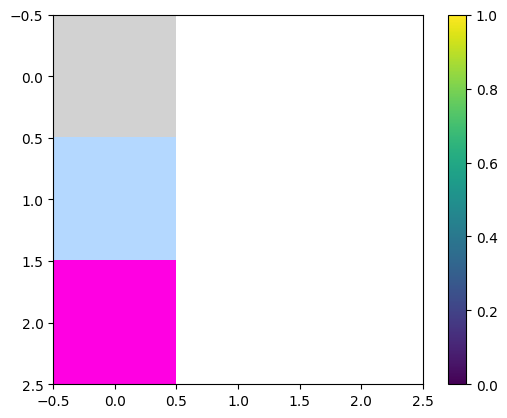

In [15]:
random_tensor = torch.randn(4, 3, 3)

plt.imshow(random_tensor.permute(1, 2, 0).numpy(), cmap="viridis")
plt.colorbar()
plt.show()

torch.Size([4, 3, 3])


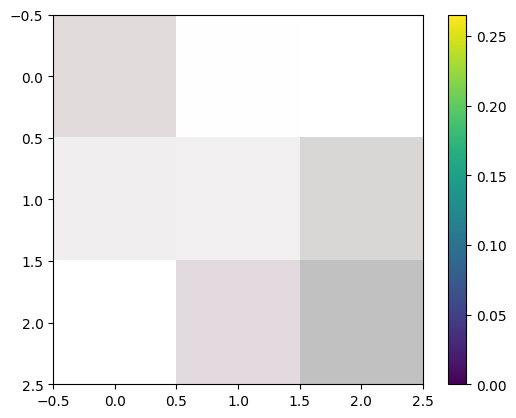

In [16]:
random_tensor = torch.randn(4, 3, 3).to(device)
nca = NeuralCA()


modifed_tensor = nca(random_tensor)

print(modifed_tensor.shape)

# Plot the modified tensor as an RGBA image
plt.imshow(modifed_tensor.cpu().permute(1, 2, 0).detach().numpy(), cmap="viridis")
plt.colorbar()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.195189..3.6198936].


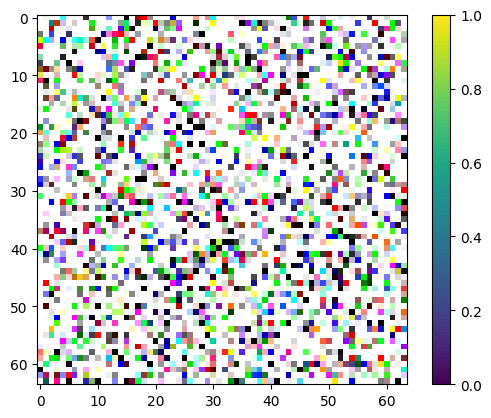

In [17]:
random_tensor = torch.randn(4, 64, 64)

plt.imshow(random_tensor.permute(1, 2, 0).numpy(), cmap="viridis")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3125426].


torch.Size([4, 64, 64])


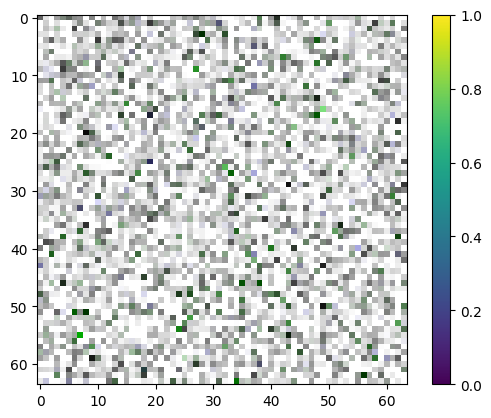

In [18]:
random_tensor = torch.randn(4, 64, 64).to(device)
nca = NeuralCA()


modifed_tensor = nca(random_tensor)

print(modifed_tensor.shape)

# Plot the modified tensor as an RGBA image
plt.imshow(modifed_tensor.cpu().permute(1, 2, 0).detach().numpy(), cmap="viridis")
plt.colorbar()
plt.show()

In [19]:
ca = NeuralCA(hidden_n=8)
[p.shape for p in ca.parameters()]  # The learnable parameters

[torch.Size([8, 4, 1, 1]),
 torch.Size([8]),
 torch.Size([4, 8, 1, 1]),
 torch.Size([4])]

In [20]:
# At the moment it's initialized with random weights:
grid = ca.grid_seed(1)
print(grid.shape)
ca.make_video(grid, name="random_nca.mp4")
Video("random_nca.mp4", width=500, height=500)

torch.Size([1, 4, 128, 128])
